In [123]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2021,9,1)
df = web.DataReader('GOOGL', 'stooq', start, end)

In [124]:
print(df)

                 Open      High       Low     Close      Volume
Date                                                           
2021-08-18  2730.0000  2742.085  2706.430  2708.980    961858.0
2021-08-17  2755.0000  2765.310  2721.640  2733.230   1085760.0
2021-08-16  2750.4979  2767.250  2705.975  2766.190   1119918.0
2021-08-13  2745.0000  2757.130  2740.660  2754.550    797372.0
2021-08-12  2719.5100  2746.000  2708.510  2743.880    825943.0
...               ...       ...       ...       ...         ...
2004-08-25    52.4800    54.000    51.940    53.000   9197800.0
2004-08-24    55.6200    55.800    51.785    52.435  15262600.0
2004-08-23    55.3750    56.740    54.525    54.700  18274400.0
2004-08-20    50.5050    54.540    50.250    54.155  22857200.0
2004-08-19    50.0000    52.030    47.980    50.170  44703800.0

[4280 rows x 5 columns]


In [125]:
def Stock_Price_LSTM_Data_Precesing(df,mem_his_days,pre_days):
    df.dropna(inplace=True)
    df.sort_index(inplace=True)

    df['label'] = df['Close'].shift(-pre_days)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])

    from collections import deque
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = df['label'].values[mem_his_days-1:-pre_days]

    import numpy as np
    X = np.array(X)
    y = np.array(y)

    return X,y,X_lately

In [126]:
X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,5,10)

In [127]:
print(len(X))
print(len(y))
print(len(X_lately))

4265
4265
10


In [ ]:
pre_days = 30
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dense_layers = [1,2,3]
# units = [16,32]
mem_days = [5]
lstm_layers = [1]
dense_layers = [1]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)

                X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                
                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM, Dense, Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
                
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))

                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))

                model.compile(optimizer='adam',
                             loss='mse',
                             metrics=['mape'])

                model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])

In [134]:
from tensorflow.keras.models import load_model
best_model = load_model('./models/8.79_07_men_5_lstm_1_dense_1_unit_32')

In [135]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(len(pre))

14/14 [==============================] - 0s 2ms/step - loss: 30790.6641 - mape: 8.7935
423


In [136]:
model.evaluate(X_test,y_test)


14/14 [==============================] - 0s 2ms/step - loss: 542585.8125 - mape: 33.3177


[542585.8125, 33.31769943237305]

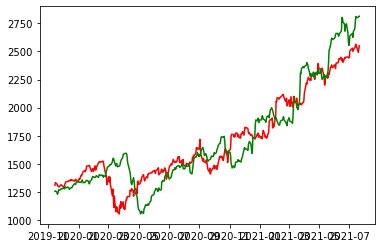

In [137]:
import matplotlib.pyplot as plt
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='red',label='price')
plt.plot(df_time,pre,color='green',label='predict')
plt.show()


In [116]:
print(len(y_test))

417
